In [8]:
import numpy as np
import pandas as pd
import random
import math
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import heapq
from typing import *
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [1]:
import sys
sys.path.insert(1, "..")
from utils.dual_space import *
from utils.linkedlist import *
from utils.ray_sweep import *

Loading the dataset from Kaggle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("eswarchandt/admission")

print("Path to dataset files:", path)

Path to dataset files: /home/mohsen/.cache/kagglehub/datasets/eswarchandt/admission/versions/1


In [3]:
data = pd.read_excel(path + "/Admission.xlsx")
data.head()

,admit,gre,gpa,ses,Gender_Male,Race,rank
0,0,380,3.61,1,0,3,3
1,1,660,3.67,2,0,2,3
2,1,800,4.00,2,0,2,1
3,1,640,3.19,1,1,2,4
4,0,520,2.93,3,1,2,4


Pre-prcessing the dataset. Converting the columns to categorial.

In [4]:
data.shape

(400, 7)

In [5]:
data.columns

Index(['admit', 'gre', 'gpa', 'ses', 'Gender_Male', 'Race', 'rank'], dtype='object')

In [6]:
gre, gpa = data["gre"], data["gpa"]

data["gre"] = (gre - gre.min()) / (gre.max() - gre.min())
data["gpa"] = (gpa - gpa.min()) / (gpa.max() - gpa.min())

Visualize the dataset.

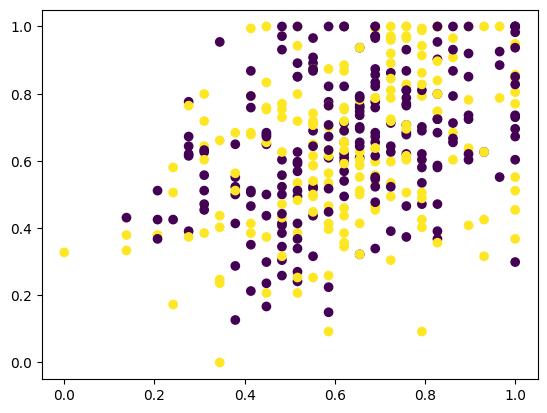

In [9]:
plt.scatter(x=data["gre"], y=data["gpa"], c=data["Gender_Male"])

Train a classification model and evaluate on whole dataset. This is the same as black-box model in the paper.

In [10]:
final_df = data.sample(frac=1, random_state=0)
target = "admit"
features = [x for x in data.columns if x != target]
X_train = final_df[features]
y_train = final_df[target]

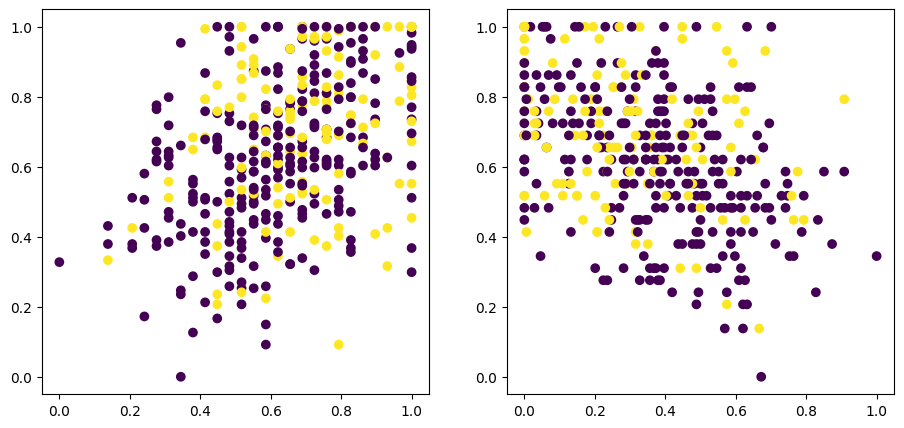

In [11]:
x_train_new = np.array(final_df[["gre", "gpa"]])
y_train_new = np.array(final_df[target])

max_y = np.max(x_train_new[:, 1])
x_train_new_prime = np.array(list(map(lambda row: [max_y - row[1] , row[0]], x_train_new)))

fig, axis = plt.subplots(1, 2, figsize=(11, 5))
axis[0].scatter(x=x_train_new[:, 0], y=x_train_new[:, 1], c=final_df[target])
axis[1].scatter(x=x_train_new_prime[:, 0], y=x_train_new_prime[:, 1], c=final_df[target])

In [12]:
x_train_new.shape, y_train_new.shape, final_df.shape, data.shape

((400, 2), (400,), (400, 7), (400, 7))

In [13]:
target = "admit"

In [14]:
features, target

(['gre', 'gpa', 'ses', 'Gender_Male', 'Race', 'rank'], 'admit')

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from joblib import dump, load

clf = MLPClassifier(random_state=1)

# Load
# clf = load('Model_MLP_1.0_v0.1.joblib')

# Train
clf.fit(data[features], data[target])

y_pred_train = clf.predict(data[features])
print(f"Accuracy on train: {accuracy_score(data[target], y_pred_train)}")
print(f"F1: {f1_score(data[target], y_pred_train)}")

Accuracy on train: 0.7075
F1: 0.36065573770491804


/home/mohsen/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Ray-sweeping algorithm

In [16]:
import time


start = time.time()
points = pd.DataFrame(x_train_new)
points_prime = pd.DataFrame(x_train_new_prime)

skew_heap = []
max_skew_1 = MaxSkewCalculator(points, skew_heap, lambda x: tuple([x[0], x[1]]), math.pi / 10)
max_skew_2 = MaxSkewCalculator(points_prime, skew_heap, lambda x: tuple([-x[1], x[0]]), math.pi / 10)

max_skew_1.preprocess()
max_skew_2.preprocess()

max_skew_1.train()
max_skew_2.train()

end = time.time()
print(f"time: {end - start}")

/home/mohsen/unknown/git_rep/Mining_U3Ms/2D/../utils/dual_space.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return sorted(keys, key=lambda x: np.arctan(x[1] / x[0]))


Number of intersects: 49027
Number of intersects: 49039
Reached Y axis, finish.
Reached Y axis, finish.
time: 3.7440340518951416


/home/mohsen/unknown/git_rep/Mining_U3Ms/2D/../utils/ray_sweep.py:88: RuntimeWarning: divide by zero encountered in scalar divide
  candidate_points, key=lambda x: np.arctan(x[1] / x[0])


Show the top directions in terms of skew value.

In [58]:
list(max_skew_2.get_high_skews(top_k=10))

[(-0.07405099781432431, (-0.42608587096237255, 0.5739141290376275)),
 (-0.06748686081090269, (-0.7647052261076681, 0.23529477389233178)),
 (-0.05473433667043374, (0.20481820493262143, 0.7951817950673786)),
 (-0.03452473967090358, (0.4117650805378104, 0.5882349194621896)),
 (-0.026085283490454702, (-0.5862047710041299, 0.41379522899587007)),
 (-0.015251349353292061, (0.5714294827630202, 0.42857051723697975)),
 (-0.006247088927021645, (-0.25000105603311723, 0.7499989439668827)),
 (-0.0006434194699888539, (0.7500015948251114, 0.2499984051748885))]

Show the tail of high skewed directions.

(0.0, 1.01)

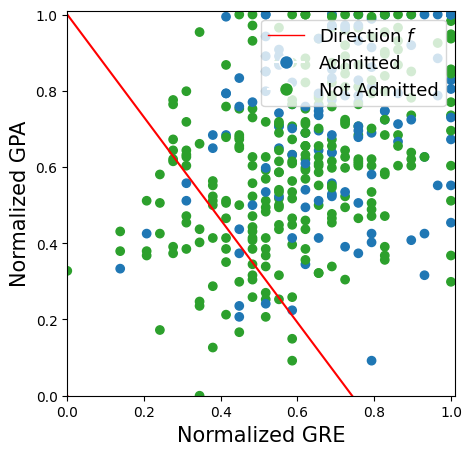

In [17]:
from matplotlib.lines import Line2D

f_direction = (-0.42608587096237255, 0.5739141290376275)

fig, ax = plt.subplots(figsize=(5,5))
points_np = np.array(points)
xmin, xmax = np.min(points_np[:, 0]), np.max(points_np[:, 0])
ymin, ymax = np.min(points_np[:, 1]), np.max(points_np[:, 1])
label = y_train_new
ax.scatter(x=points_np.T[0], y=points_np.T[1], c=["#1f77b4" if x==1 else "#2ca02c" for x in label])
x = np.arange(xmin, 2 * xmax)
f = f_direction
f = f / linalg.norm(f)
y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
ax.plot(x, y, color="red")
ax.plot(x, y + max(ymax, xmax), color="red")
plt.xlabel("Normalized GRE", fontsize=15)
plt.ylabel("Normalized GPA", fontsize=15)

line = Line2D([0], [0], label='Direction $f$', color='red', linewidth=1)
b = Line2D([0], [0], marker='o', color='w', label='Admitted', markerfacecolor='#1f77b4', markersize=10)
b2 = Line2D([0], [0], marker='o', color='w', label='Not Admitted', markerfacecolor='#2ca02c', markersize=10)
ax.legend(handles=[line, b, b2], fontsize=13, loc="upper right")

plt.xlim(xmin, xmax + 0.01)
plt.ylim(ymin, ymax + 0.01)

In [18]:
f = np.array(f)
p_f = np.dot(points, f)
mean = np.mean(p_f)
sd = np.std(p_f)
median = np.median(p_f)
sk = (mean - median) / sd
print("skew value is:", sk)

skew value is: -0.05551913068223193


Show the tail of skew.

/tmp/ipykernel_454558/3374412662.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tail = data[df.apply(lambda x: np.dot((x[0], x[1]), f) < q1 if -sk < 0 else np.dot((x[0], x[1]), f) > q1, axis=1)]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(39, 7) (400, 2)


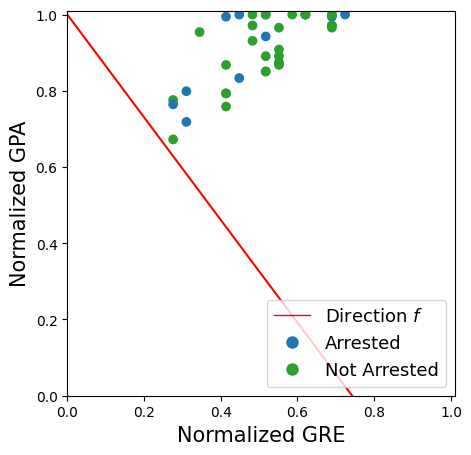

In [142]:
q = 0.1 # percentile of tail

df = data.copy(deep=True)
df = df[["gre", "gpa"]]

df["gre"] = (data["gre"] - data["gre"].min()) / (data["gre"].max() - data["gre"].min())
df["gpa"] = (data["gpa"] - data["gpa"].min()) / (data["gpa"].max() - data["gpa"].min())

q1 = np.quantile(np.dot(df[["gre", "gpa"]], f), q if -sk < 0 else (1 - q))
tail = data[df.apply(lambda x: np.dot((x[0], x[1]), f) < q1 if -sk < 0 else np.dot((x[0], x[1]), f) > q1, axis=1)]
print(tail.shape, df.shape)

fig, ax = plt.subplots(figsize=(5,5))
points_np = np.array(tail[["gre", "gpa"]])
label = tail["Gender_Male"]
ax.scatter(x=points_np.T[0], y=points_np.T[1], c=["#1f77b4" if x==1 else "#2ca02c" for x in label])
x = np.arange(xmin, 2 * xmax)
f = f / linalg.norm(f)
y = np.array(list(map(lambda x: x * f[1] / f[0], x)))
ax.plot(x, y, color="red")
ax.plot(x, y + max(ymax, xmax), color="red")

line = Line2D([0], [0], label='Direction $f$', color='red', linewidth=1)
b = Line2D([0], [0], marker='o', color='w', label='Arrested', markerfacecolor='#1f77b4', markersize=10)
b2 = Line2D([0], [0], marker='o', color='w', label='Not Arrested', markerfacecolor='#2ca02c', markersize=10)
ax.legend(handles=[line, b, b2], fontsize=13, loc="lower right")

plt.xlim(xmin, xmax + 0.01)
plt.ylim(ymin, ymax + 0.01)
plt.xlabel("Normalized GRE", fontsize=15)
plt.ylabel("Normalized GPA", fontsize=15)

Get statistics about the tail.

In [118]:
data["Gender_Male"].value_counts(), tail["Gender_Male"].value_counts(), tail["Gender_Male"].value_counts()[0] / tail["Gender_Male"].value_counts()[1]

(Gender_Male
 0    210
 1    190
 Name: count, dtype: int64,
 Gender_Male
 1    3
 0    1
 Name: count, dtype: int64,
 0.3333333333333333)

In [ ]:
percentiles = [1.0, 0.5, 0.2, 0.1, 0.08, 0.04]
directions = [
    (-0.42608587096237255, 0.5739141290376275),
    (-0.7647052261076681, 0.23529477389233178),
    (0.20481820493262143, 0.7951817950673786)
]

results = {
    "percentile": [],
    "tail_female_ratio": [],
    "total_female_ratio": [],
    "skew_rank": [],
    "accuracy": [],
    "f1_score": []
}

for (i, f) in enumerate(directions):
    for q in percentiles:
        q1 = np.quantile(np.dot(df[["gre", "gpa"]], f), q if -sk < 0 else (1 - q))
        tail = data[df.apply(lambda x: np.dot((x[0], x[1]), f) < q1 if -sk < 0 else np.dot((x[0], x[1]), f) > q1, axis=1)]

        data_sample_train = tail[features]
        data_sample_target = tail[target]

        y_pred_train = clf.predict(np.array(data_sample_train))

        results["percentile"].append(q)
        results["tail_female_ratio"].append(tail["Gender_Male"].value_counts()[0] / tail["Gender_Male"].value_counts()[1])
        results["total_female_ratio"].append(data["Gender_Male"].value_counts()[0] / data["Gender_Male"].value_counts()[1])
        results["skew_rank"].append(i + 1)
        results["accuracy"].append(accuracy_score(data_sample_target, y_pred_train))
        results["f1_score"].append(f1_score(data_sample_target, y_pred_train))


In [124]:
output = pd.DataFrame(results)
output.head()

,percentile,tail_female_ratio,total_female_ratio,skew_rank,accuracy,f1_score
0,1.00,1.111111,1.105263,1,0.709273,0.362637
1,0.50,1.127660,1.105263,1,0.685000,0.422018
2,0.20,0.818182,1.105263,1,0.675000,0.480000
3,0.10,2.000000,1.105263,1,0.615385,0.347826
4,0.08,1.818182,1.105263,1,0.645161,0.421053


In [131]:
tmp = output[output["skew_rank"] == 1]
tmp

,percentile,tail_female_ratio,total_female_ratio,skew_rank,accuracy,f1_score
0,1.00,1.111111,1.105263,1,0.709273,0.362637
1,0.50,1.127660,1.105263,1,0.685000,0.422018
2,0.20,0.818182,1.105263,1,0.675000,0.480000
3,0.10,2.000000,1.105263,1,0.615385,0.347826
4,0.08,1.818182,1.105263,1,0.645161,0.421053
5,0.04,1.500000,1.105263,1,0.800000,0.400000


Evaluate the model on the tail.

In [78]:
from sklearn.metrics import f1_score

data_sample_train = tail[features]
data_sample_target = tail[target]

y_pred_train = clf.predict(np.array(data_sample_train))
print(f"Accuracy on train: {accuracy_score(data_sample_target, y_pred_train)}")
print(f"F1: {f1_score(data_sample_target, y_pred_train)}")

Accuracy on train: 0.6153846153846154
F1: 0.34782608695652173


/home/mohsen/venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
